# 1. Load packages

The link to get [ImageAnalysis3](https://github.com/zhengpuas47/ImageAnalysis3) 

or the Zhuang lab archived [source_tools](https://github.com/ZhuangLab/Chromatin_Analysis_2020_cell/tree/master/sequential_tracing/source)

In [1]:
%run "C:\Users\shiwei\Documents\ImageAnalysis3\required_files\Startup_py3.py"
sys.path.append(r"C:\Users\shiwei\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

import pandas as pd

46780


See **functions** in the repository for [AnalysisTool_Chromatin](../../functions/README.md)

In [2]:
# Chromatin_analysis_tools (ATC)
# Get path for the py containing functions
import os
import sys
import importlib
module_path =r'C:\Users\shiwei\Documents\AnalysisTool_Chromatin'
if module_path not in sys.path:
    sys.path.append(module_path)
    
# import relevant modules
import gene_selection 
importlib.reload(gene_selection)
import gene_to_loci
importlib.reload(gene_to_loci)
import gene_activity
importlib.reload(gene_activity)
import loci_1d_features
importlib.reload(loci_1d_features)  

import atac_to_loci
importlib.reload(atac_to_loci)

<module 'atac_to_loci' from 'C:\\Users\\shiwei\\Documents\\AnalysisTool_Chromatin\\atac_to_loci.py'>

In [3]:
import seaborn as sns
import scanpy as sc

## 1.1 Define output folder

In [39]:
output_main_folder = r'L:\Shiwei\Figures\MOp_draft_2023_v2\Nuclear_organization_v2'
output_analysis_folder = os.path.join(output_main_folder, 'analysis')
output_figure_folder = os.path.join(output_main_folder, 'figures')

make_output_folder = True

if make_output_folder and not os.path.exists(output_analysis_folder):
    os.makedirs(output_analysis_folder)
    print(f'Generating analysis folder: {output_analysis_folder}.')
elif os.path.exists(output_analysis_folder):
    print(f'Use existing analysis folder: {output_analysis_folder}.')
    
if make_output_folder and not os.path.exists(output_figure_folder):
    os.makedirs(output_figure_folder)
    print(f'Generating figure folder: {output_figure_folder}.')
elif os.path.exists(output_figure_folder):
    print(f'Use existing figure folder: {output_figure_folder}.')


Use existing analysis folder: L:\Shiwei\Figures\MOp_draft_2023_v2\Nuclear_organization_v2\analysis.
Use existing figure folder: L:\Shiwei\Figures\MOp_draft_2023_v2\Nuclear_organization_v2\figures.


## 1.2 setting up plotting parameters

In [5]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

import matplotlib
%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42

plt.rc('font', family='serif')
plt.rc('font', serif='Arial')


# Other required plotting parameters
_dpi = 300
_font_size = 7.5
_page_width = 5.5

sc.settings.n_jobs = 24
sc.settings.set_figure_params(dpi=_dpi/2, dpi_save=_dpi, frameon=False, 
                              figsize=(_page_width/2, _page_width/2), fontsize=_font_size, facecolor='white', transparent=True)
sc.settings.figdir = output_figure_folder

In [6]:
# cell labels from RNA-MERFISH and celltype prediction
selected_cell_labels = ['L2/3 IT','L4/5 IT','L5 IT','L6 IT','L5 ET','L5/6 NP','L6 CT','L6b',
                           'Sst','Pvalb','Lamp5','Sncg','Vip',
                           'Astro','Oligo','OPC','Micro','Endo','VLMC','SMC','Peri', 
                           #'other',
                          ]
# cell palette from RNA-MERFISH UMAP and stats
celltype_palette = {'Astro':'lightcoral', 
                    'Endo':'skyblue', 
                    'L2/3 IT':'gold', 
                    'L4/5 IT':'darkorange', 
                    'L5 ET':'mediumseagreen', 
                    'L5 IT':'aqua',
                    'L5/6 NP':'darkgreen',
                    'L6 CT':'brown',
                    'L6 IT':'magenta',
                    'L6b':'blue', 
                    'Lamp5':'orange', 
                    'Micro':'peachpuff',
                    'OPC':'thistle', 
                    'Oligo':'darkviolet',
                    'Peri':'sandybrown',
                    'Pvalb':'springgreen',
                    'SMC':'rosybrown',
                    'Sncg':'darkkhaki',
                    'Sst':'steelblue', 
                    'VLMC':'saddlebrown', 
                    'Vip':'red',
                    'other':'slategray'}


In [7]:
# this is the plotting order noted based on the snRNA transcriptional acitivty;
# we'd use this for all the graphs in this notebook
# use the snRNA data below (# section 3.1.1) if needs to re-calculate
sorted_cellplot_order = ['Micro', 'Oligo', 'Endo', 'OPC', 'Astro', 'Vip', 'Lamp5',
                  'L5/6 NP', 'Sst', 'Sncg', 'Pvalb', 'L4/5 IT', 'L6 CT',
                  'L6 IT', 'L6b', 'L2/3 IT', 'L5 IT', 'L5 ET']

# 2. Load codebook and nucleus size

## Codebook

See **codebook** example from [codebook](../../0_locus_annotation/resources/MERFISH_loci_adjacent_genes_tss_more_res.csv)

In [8]:
# load codebook
# L drive is Crick Pu_SSD_0
codebook_save_folder=r'C:\Users\shiwei\Documents\AnalysisTool_Chromatin\resources'

# Load sorted codebook (allows direct matrix slicing) with cell type info
# Load codebook (then sort to allow direct matrix slicing) with cell type info

codebook_fname = os.path.join(codebook_save_folder,'MERFISH_loci_adjacent_genes_tss_more_res.csv')
codebook_df = pd.read_csv (codebook_fname, index_col=0)

# sort df temporailiy so matrix can be sliced by df order directly
codebook_df = loci_1d_features.sort_loci_df_by_chr_order (codebook_df)

codebook_df.head()

,name,id,chr,chr_order,library,dtype,adjacent_genes_0kb_tss,adjacent_genes_10kb_tss,adjacent_genes_50kb_tss,adjacent_genes_100kb_tss,adjacent_genes_200kb_tss,adjacent_genes_500kb_tss,adjacent_genes_1000kb_tss,adjacent_genes_1500kb_tss,adjacent_genes_2000kb_tss
loci_name,,,,,,,,,,,,,,,
chr1_3742742_3759944,1:3742742-3759944,1,1,0,CTP11,combo,intergenic,intergenic,intergenic,Xkr4,Xkr4,Gm18956; Gm7341; Xkr4,Gm18956; Gm2053; Gm6085; Gm6101; Gm6119; Gm734...,Atp6v1h; Gm16041; Gm17101; Gm18956; Gm2053; Gm...,Atp6v1h; Gm16041; Gm17101; Gm18956; Gm2053; Gm...
chr1_6245958_6258969,1:6245958-6258969,2,1,1,CTP11,combo,intergenic,intergenic,4732440D04Rik; Rb1cc1,4732440D04Rik; Rb1cc1,4732440D04Rik; Gm19026; Gm2147; Rb1cc1,4732440D04Rik; Gm19026; Gm2147; Npbwr1; Rb1cc1...,4732440D04Rik; Gm19026; Gm2147; Gm5694; Gm7182...,4732440D04Rik; Atp6v1h; Gm16041; Gm17101; Gm19...,4732440D04Rik; Atp6v1h; Gm16041; Gm17101; Gm19...
chr1_8740008_8759916,1:8740008-8759916,3,1,2,CTP11,combo,intergenic,intergenic,Gm15452,Gm15452,Gm15452,Gm15452,1700034P13Rik; 2610203C22Rik; Adhfe1; Gm15452;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...
chr1_9627926_9637875,1:9627926-9637875,1,1,3,CTP13,combo,2610203C22Rik,2610203C22Rik,2610203C22Rik,2610203C22Rik; Adhfe1; Gm6161; Mybl1; Rrs1,1700034P13Rik; 2610203C22Rik; Adhfe1; Gm18300;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Cops5; C...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; A830018L16Rik; A...
chr1_9799472_9811359,1:9799472-9811359,2,1,4,CTP13,combo,Gm6195,Gm6195; Sgk3,Gm6195; Sgk3,1700034P13Rik; Gm6195; Mcmdc2; Mybl1; Sgk3; Vc...,1700034P13Rik; 2610203C22Rik; Gm6195; Mcmdc2; ...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; A830018L16Rik; A...


# 3. Plot figures

## Total transcriptional activity and nucleus size

### 10x snRNAseq data (MOp)

Processed snRNAseq data can be generated by notebook from below:

[external/scripts/sn_rna/2_prepare_and_rename_sn_rna_mop](../../external/scripts/sn_rna/2_prepare_and_rename_sn_rna_mop.ipynb)

In [9]:
import scanpy as sc

sn_RNA_folder = r'L:\Shiwei\DNA_MERFISH_analysis\10x_nuclei_v3_MOp_AIBS\Analysis_10X_nuclei_v3_AIBS\processed'
sn_adata = sc.read(os.path.join(sn_RNA_folder,r'MOp_10x_sn_labeled.h5ad'))

sn_adata_ori = sn_adata.raw.to_adata()

In [10]:
measure_df = sn_adata_ori.obs[['umi.counts','total_counts','n_genes_by_counts','subclass_label_new','class_label_new','neuron_identity']]
sel_measure_df = measure_df[measure_df['subclass_label_new'].isin(selected_cell_labels)]
sel_measure_df

,umi.counts,total_counts,n_genes_by_counts,subclass_label_new,class_label_new,neuron_identity
AAACCCAAGCTCTTCC-1L8TX_181211_01_A02,28466,28466.0,4772,L6b,Gluta,Neuronal
AAACCCAAGTCGAATA-1L8TX_181211_01_A02,19669,19669.0,3803,L6 CT,Gluta,Neuronal
AAACCCACAACCCTAA-1L8TX_181211_01_A02,9296,9296.0,2485,Vip,GABA,Neuronal
AAACCCAGTATAGCTC-1L8TX_181211_01_A02,14204,14204.0,3234,L4/5 IT,Gluta,Neuronal
AAACCCAGTCAGACTT-1L8TX_181211_01_A02,21334,21334.0,3828,L2/3 IT,Gluta,Neuronal
...,...,...,...,...,...,...
TTTGTTGGTCAGTCGC-5L8TX_181211_01_H01,14092,14092.0,3424,Pvalb,GABA,Neuronal
TTTGTTGGTTGCGAAG-5L8TX_181211_01_H01,16467,16467.0,3607,L6 CT,Gluta,Neuronal
TTTGTTGTCCCTAGGG-5L8TX_181211_01_H01,18615,18615.0,3961,Pvalb,GABA,Neuronal
TTTGTTGTCCTGGTCT-5L8TX_181211_01_H01,23216,23216.0,4094,L6 IT,Gluta,Neuronal


In [11]:
# sort plotting order by meadian of groups
sel_measure_df_mean = pd.DataFrame(sel_measure_df.groupby(by='subclass_label_new')['umi.counts'].median())
sel_measure_df_mean = sel_measure_df_mean.sort_values(by='umi.counts')
sorted_cellplot_order = sel_measure_df_mean.index
sorted_cellplot_order

CategoricalIndex(['Micro', 'Oligo', 'Endo', 'OPC', 'Astro', 'Vip', 'Lamp5',
                  'L5/6 NP', 'Sst', 'Sncg', 'Pvalb', 'L4/5 IT', 'L6 CT',
                  'L6 IT', 'L6b', 'L2/3 IT', 'L5 IT', 'L5 ET'],
                 categories=['Astro', 'Endo', 'L2/3 IT', 'L5 ET', ..., 'Pvalb', 'Sncg', 'Sst', 'Vip'], ordered=False, dtype='category', name='subclass_label_new')

meta NOT subset; don't know how to subset; dropped


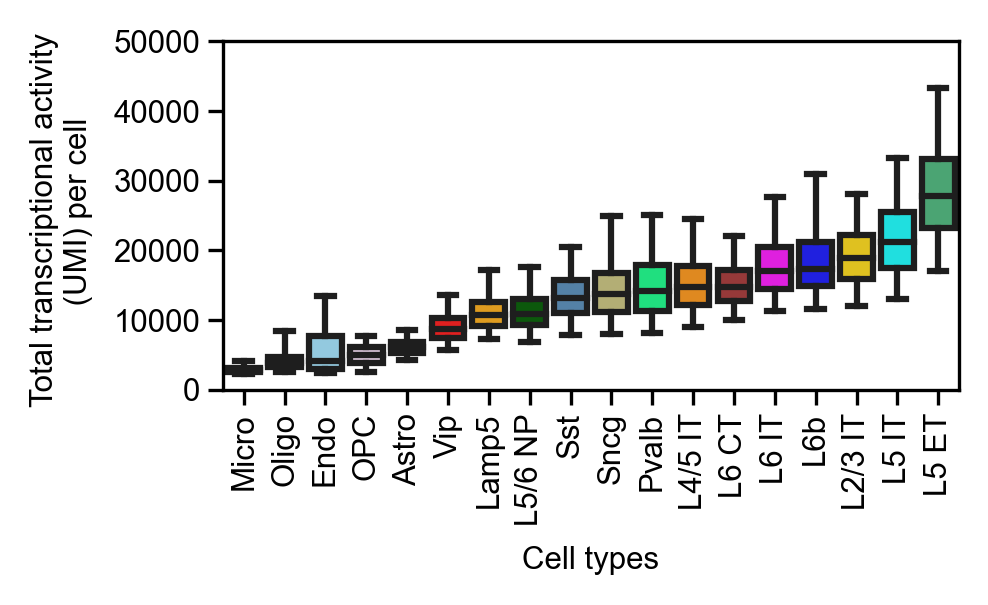

In [12]:
%matplotlib inline

import seaborn as sns
import scanpy as sc

# plot
fig, ax = plt.subplots(figsize=(_page_width/3.5*5/2.5,_page_width/3.6),dpi=150)

sns.boxplot(data=sel_measure_df, x='subclass_label_new', y='umi.counts', 
            order = sorted_cellplot_order, 
            ax=ax, 
            fliersize=0,
            whis=[5, 95],
            #boxprops={'linewidth': 0.5}
            palette=celltype_palette)

#ax.set_xticklabels(sorted_types, rotation=70, fontsize=12)
plt.tick_params(axis='y', labelsize=_font_size, pad=2) 
plt.tick_params(axis='x', rotation=90, labelsize=_font_size, pad=2) 

ax.set_xlabel("Cell types", fontsize=_font_size, labelpad=5)
ax.set_ylabel("Total transcriptional activity \n (UMI) per cell", fontsize=_font_size, labelpad=5)


ax.set_ylim([0,50000])
ax.grid(False)

plt.savefig(os.path.join(output_figure_folder, f'10x_snRNAseq_UMI.pdf'), 
            transparent=True, dpi=300, bbox_inches='tight')

plt.show()



### Human M1 snRNAseq data

Processed data can be generated by notebook below:

[external/scripts/sn_rna_human/2_prepare_and_rename_sn_rna_hm1](../../external/scripts/sn_rna_human/2_prepare_and_rename_sn_rna_hm1.ipynb)

In [14]:
import scanpy as sc
#import os

sn_RNA_folder = r'L:\Shiwei\DNA_MERFISH_analysis\hM1_10x'
sn_adata = sc.read(os.path.join(sn_RNA_folder,r'hM1_10X_labeled_newname.h5ad'))

sn_adata_ori = sn_adata.raw.to_adata()

In [16]:
np.unique(sn_adata_ori.obs['subclass_label_new'])

array(['Astro', 'Endo', 'L2/3 IT', 'L4/5 IT', 'L5 ET', 'L5 IT', 'L5/6 NP',
       'L6 CT', 'L6 IT', 'L6 IT Car3', 'L6b', 'Lamp5', 'Micro', 'OPC',
       'Oligo', 'Pvalb', 'Sncg', 'Sst', 'Sst Chodl', 'VLMC', 'Vip'],
      dtype=object)

In [17]:
measure_df_hM1 = sn_adata_ori.obs[['total_counts','n_genes_by_counts','subclass_label_new','class_label_new',]]
measure_df_hM1 = measure_df_hM1[measure_df_hM1['subclass_label_new'].isin(sorted_cellplot_order)]
measure_df_hM1

,total_counts,n_genes_by_counts,subclass_label_new,class_label_new
sample_name,,,,
AAACCCAAGGATTTCC-LKTX_190129_01_A01,14396.0,4815,Sst,GABA
AAACCCAAGTATGGCG-LKTX_190129_01_A01,12027.0,4372,L5/6 NP,Gluta
AAACCCACAAAGTGTA-LKTX_190129_01_A01,16112.0,5280,L4/5 IT,Gluta
AAACCCACACTACTTT-LKTX_190129_01_A01,2994.0,1649,L2/3 IT,Gluta
AAACCCACAGTGAGCA-LKTX_190129_01_A01,5202.0,2499,Oligo,Oligo
...,...,...,...,...
TTTGTTGAGATGGCGT-LKTX_190130_01_H01,2608.0,1498,Oligo,Oligo
TTTGTTGCACAGCCAC-LKTX_190130_01_H01,32223.0,7018,L5 IT,Gluta
TTTGTTGCAGAGACTG-LKTX_190130_01_H01,2032.0,1279,L2/3 IT,Gluta


meta NOT subset; don't know how to subset; dropped


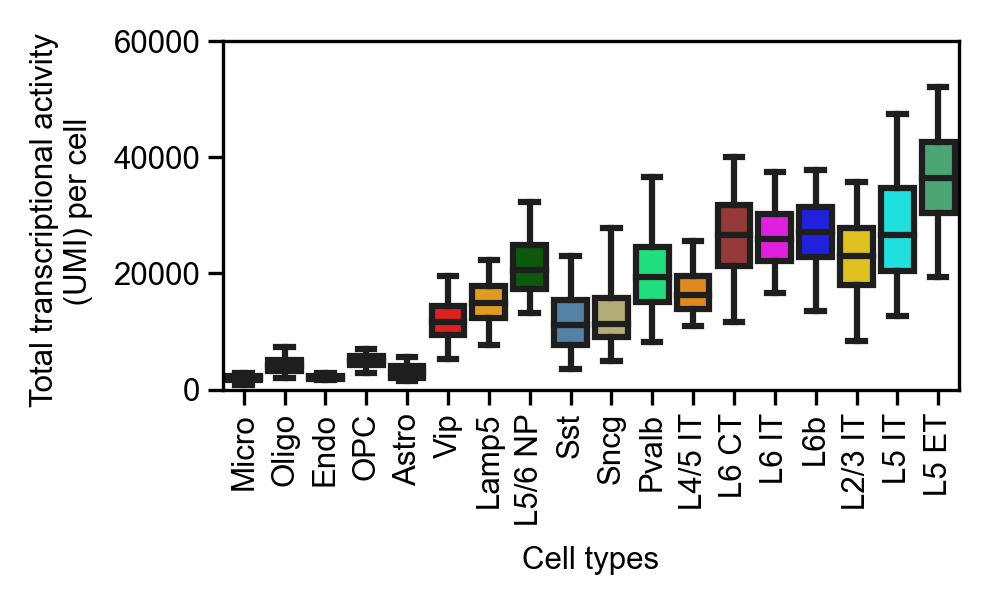

In [18]:
%matplotlib inline

import seaborn as sns
import scanpy as sc

# plot
#fig, ax = plt.subplots(figsize=(_page_width/4*5/3,_page_width/4),dpi=150)
fig, ax = plt.subplots(figsize=(_page_width/3.5*5/2.5,_page_width/3.6),dpi=150)

sns.boxplot(data=measure_df_hM1, x='subclass_label_new', y='total_counts', 
            order = sorted_cellplot_order, 
            ax=ax, 
            fliersize=0,
            whis=[5, 95],
            #boxprops={'linewidth': 0.5}
            palette=celltype_palette)

#ax.set_xticklabels(sorted_types, rotation=70, fontsize=12)
plt.tick_params(axis='y', labelsize=_font_size, pad=2) 
plt.tick_params(axis='x', rotation=90, labelsize=_font_size, pad=2) 

ax.set_xlabel("Cell types", fontsize=_font_size, labelpad=5)
ax.set_ylabel("Total transcriptional activity \n (UMI) per cell", fontsize=_font_size, labelpad=5)


ax.set_ylim([0,60000])
ax.grid(False)

plt.savefig(os.path.join(output_figure_folder, f'10x_hM1_snRNAseq_UMI.pdf'), 
            transparent=True, dpi=300, bbox_inches='tight')

plt.show()



### Human 4000 genes MERFISH

Data below is descirbed in the notebook:

[external/scripts/merfish_4000/1_human_mtg_merfish_inspection](../../external/scripts/merfish_4000/1_human_mtg_merfish_inspection.ipynb)

In [19]:
ref_folder = r'L:\Shiwei\DNA_MERFISH_analysis\MERFISH_MTG_STG\doi_10.5061_dryad.x3ffbg7mw__v16'
ref_fname = os.path.join(ref_folder, r'MTG_4000_MERFISH_raw.h5ad')

ref_raw_adata = sc.read_h5ad(ref_fname)

C:\Users\shiwei\Anaconda3\envs\shiwei_chromatin\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [20]:
ref_raw_adata.obs_names_make_unique()

np.unique(ref_raw_adata.obs['cluster_L2'].tolist())

array(['eL2/3.IT', 'eL4/5.IT', 'eL5.ET', 'eL5.IT', 'eL5/6.NP', 'eL6.CT',
       'eL6.IT', 'eL6.IT.CAR3', 'eL6b', 'iLAMP5', 'iPVALB', 'iSST',
       'iVIP', 'lASC', 'lMGC', 'lOGC', 'lOPC', 'oENDO', 'oMURAL'],
      dtype='<U11')

In [21]:
ref_raw_adata.obs['subclass_label_new'] = ref_raw_adata.obs['cluster_L2'] 

new_subclass_dict = {'eL2/3.IT':'L2/3 IT', 
                     'eL4/5.IT':'L4/5 IT',
                     'eL5.ET':'L5 ET', 
                     'eL5.IT':'L5 IT', 
                     'eL5/6.NP':'L5/6 NP', 
                     'eL6.CT':'L6 CT',
                     'eL6.IT':'L6 IT', 
                     'eL6b':'L6b', 
                     'iLAMP5':'Lamp5',
                     'iPVALB':'Pvalb',
                     'iLAMP5':'Lamp5',
                     'iSST':'Sst',
                     'iVIP':'Vip',
                     'lASC':'Astro', 'lMGC':'Micro', 'lOGC':'Oligo', 'lOPC':'OPC', 'oENDO':'Endo', }

ref_raw_adata.obs = ref_raw_adata.obs.replace({'subclass_label_new':new_subclass_dict})
np.unique(ref_raw_adata.obs['subclass_label_new'].tolist())

array(['Astro', 'Endo', 'L2/3 IT', 'L4/5 IT', 'L5 ET', 'L5 IT', 'L5/6 NP',
       'L6 CT', 'L6 IT', 'L6b', 'Lamp5', 'Micro', 'OPC', 'Oligo', 'Pvalb',
       'Sst', 'Vip', 'eL6.IT.CAR3', 'oMURAL'], dtype='<U11')

In [22]:
hm_sorted_cellplot_order = ['Micro', 'Oligo', 'Endo', 'OPC', 'Astro', 
                           'Vip', 'Lamp5', 
                  'L5/6 NP', 'Sst',  'Pvalb', 'L4/5 IT', 'L6 CT',
                  'L6 IT','L6b','L2/3 IT', 'L5 IT', 'L5 ET']
measure_df3 = ref_raw_adata.obs[['total_counts','n_genes_by_counts','subclass_label_new']]
sel_measure_df3 = measure_df3[measure_df3['subclass_label_new'].isin(hm_sorted_cellplot_order)]
sel_measure_df3

,total_counts,n_genes_by_counts,subclass_label_new
fov_101_feature_3,3976,1202,L5 IT
fov_101_feature_5,1908,804,L5 IT
fov_101_feature_6,2069,840,L5/6 NP
fov_102_feature_3,3136,1165,L5 IT
fov_102_feature_5,2552,984,L5 IT
...,...,...,...
240495259594138995563004271519025383450,950,334,Endo
55265280608044589891114722178780662498,284,124,Endo
307732216481176265751988896560759716047,268,130,Endo
92931439707904599931293188460431397820,417,199,Endo


meta NOT subset; don't know how to subset; dropped


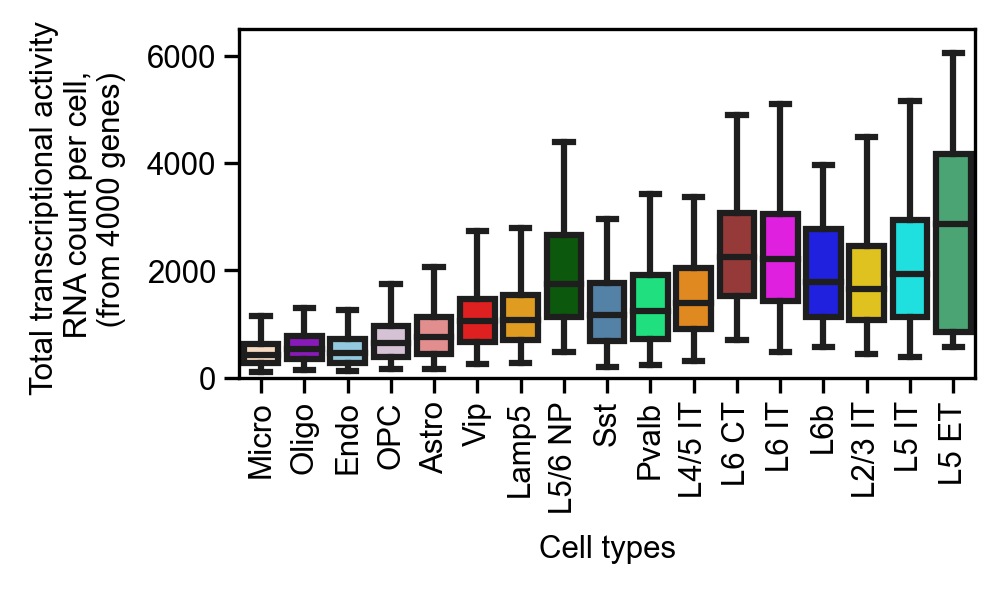

In [23]:
%matplotlib inline
import seaborn as sns
import scanpy as sc

# plot
#fig, ax = plt.subplots(figsize=(_page_width/4*5/3,_page_width/4),dpi=150)
fig, ax = plt.subplots(figsize=(_page_width/3.5*5/2.5,_page_width/3.6),dpi=150)

sns.boxplot(data=sel_measure_df3, x='subclass_label_new', y='total_counts', 
            order = hm_sorted_cellplot_order, 
            ax=ax, 
            fliersize=0,
            whis=[5, 95],
            #boxprops={'linewidth': 0.5}
            palette=celltype_palette)

plt.tick_params(axis='y', labelsize=_font_size, pad=2) 
plt.tick_params(axis='x', rotation=90, labelsize=_font_size, pad=2) 

ax.set_xlabel("Cell types", fontsize=_font_size, labelpad=5)
ax.set_ylabel("Total transcriptional activity \n RNA count per cell, \n (from 4000 genes)", fontsize=_font_size, labelpad=5)


ax.set_ylim([0,6500])
ax.grid(False)

plt.savefig(os.path.join(output_figure_folder, f'hMTG_4000_MERFISH_total_counts.pdf'), 
            transparent=True, dpi=300, bbox_inches='tight')

plt.show()

## Nucleus size

Below nuclear volume data can be generated by the notebook below:

[3_nuclei_size_by_convexhull_singlecell_dataframe](3_nuclei_size_by_convexhull_singlecell_dataframe.ipynb)

In [24]:
output_fname = os.path.join(output_analysis_folder, f'nucleus_volume_convexhull_bysubclass.csv')

merged_cell_volume_df = pd.read_csv(output_fname, index_col=0)
merged_cell_volume_df

,subclass,nucleus_volume,total_spots
uid,,,
259202492748634617304623818845147108919,Oligo,255.043678,863
336074706103419484501535095917410831417,Oligo,298.589934,1426
179117357717369278884189379535888871018,Oligo,305.797609,1601
36321914521561890358202806077673807953,Oligo,76.777445,210
92271180002801802991585284299263797402,Oligo,376.983590,2034
...,...,...,...
89559371323596133331060964655277765256,VLMC,183.802964,584
144314319466287448491677682735506973,VLMC,92.940088,387
71119619609696733523981100580894538756,VLMC,237.601248,734


In [25]:
selected_cell_labels = ['L2/3 IT','L4/5 IT','L5 IT','L6 IT','L5 ET','L5/6 NP','L6 CT','L6b',
                           'Sst','Pvalb','Lamp5',
                           'Astro','Oligo','OPC','Micro','Endo','Peri', 
                           
                          ]

celltype_palette = {'Astro':'lightcoral', 
                    'Endo':'skyblue', 
                    'L2/3 IT':'gold', 
                    'L4/5 IT':'darkorange', 
                    'L5 ET':'mediumseagreen', 
                    'L5 IT':'aqua',
                    'L5/6 NP':'darkgreen',
                    'L6 CT':'brown',
                    'L6 IT':'magenta',
                    'L6b':'blue', 
                    'Lamp5':'orange', 
                    'Micro':'peachpuff',
                    'OPC':'thistle', 
                    'Oligo':'darkviolet',
                    'Peri':'sandybrown',
                    'Pvalb':'springgreen',
                    'SMC':'rosybrown',
                    'Sncg':'darkkhaki',
                    'Sst':'steelblue', 
                    'VLMC':'saddlebrown', 
                    'Vip':'red',
                    'other':'slategray'}


sel_merged_cell_volume_df = merged_cell_volume_df[merged_cell_volume_df['subclass'].isin(sorted_cellplot_order)]

### Check scatter of min pts th and nucleus size

turning point indicating potential doublet: 1250


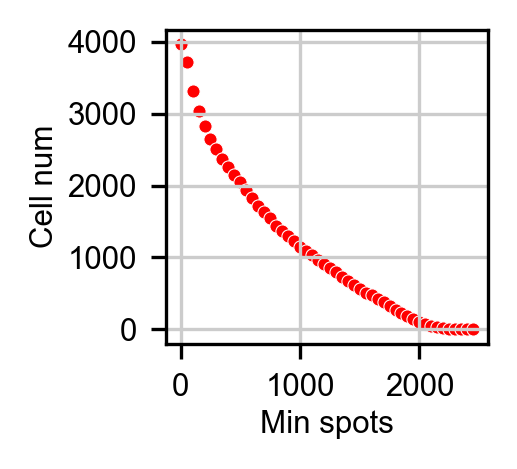

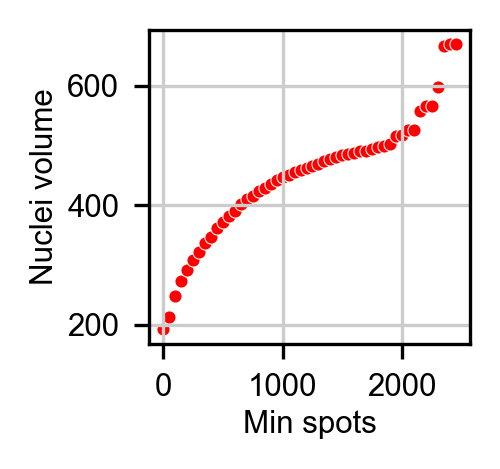

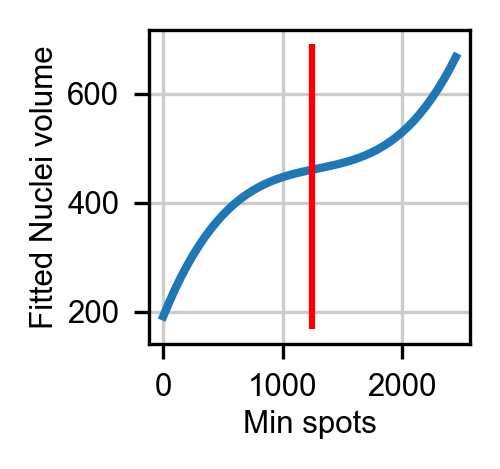

In [26]:
x = []
y = []
c = []
for min_pts_th in np.arange(0,2500,50):
    df_plot = sel_merged_cell_volume_df[sel_merged_cell_volume_df['total_spots']>=min_pts_th]
    #df_plot = df_plot[df_plot['subclass']=='Oligo']
    df_plot = df_plot[df_plot['subclass']=='L2/3 IT']
    y.append(np.median(df_plot['nucleus_volume']))
    x.append(min_pts_th)
    c.append(len(df_plot))
    
fig, ax = plt.subplots(figsize=(_page_width/4,_page_width/4),dpi=150)
#sns.lineplot(x=x, y=c, ax=ax, )
sns.scatterplot(x=x, y=c, ax=ax, c='r',s=10)
ax.set_xlabel("Min spots", fontsize=_font_size, labelpad=2)
ax.set_ylabel("Cell num", fontsize=_font_size, labelpad=2)

fig, ax = plt.subplots(figsize=(_page_width/4,_page_width/4),dpi=150)
#sns.lineplot(x=x, y=y, ax=ax, )
sns.scatterplot(x=x, y=y, ax=ax, c='r',s=10)
ax.set_xlabel("Min spots", fontsize=_font_size, labelpad=2)
ax.set_ylabel("Nuclei volume", fontsize=_font_size, labelpad=2)

# fit with 3 order polynomial for data in range (0-2000)
fig, ax = plt.subplots(figsize=(_page_width/4,_page_width/4),dpi=150)
coefs = np.polyfit(x,y, 3)
p = np.poly1d(coefs)
y_fit = p(x)
#sns.scatterplot(x=x, y=y, ax=ax, c='r',s=10)
sns.lineplot(x=x, y=y_fit, ax=ax, linewidth=2)
ax.set_xlabel("Min spots", fontsize=_font_size, labelpad=2)
ax.set_ylabel("Fitted Nuclei volume", fontsize=_font_size, labelpad=2)


# get turning point from 2nd derivative
dy=np.diff(y_fit,1)
dx=np.diff(x,1)
yfirst = dy/dx
xfirst = 0.5*(np.array(x)[:-1]+np.array(x)[1:])
dyfirst = np.diff(yfirst,1)
dxfirst = np.diff(xfirst,1)
dysecond = dyfirst/dxfirst
sel_x = x[np.where(dysecond>0)[0][0]]
print ('turning point indicating potential doublet:',sel_x)
ax.vlines(sel_x, ymin=min(ax.get_ylim()),ymax=max(ax.get_ylim()), color='red')

plt.show()

meta NOT subset; don't know how to subset; dropped


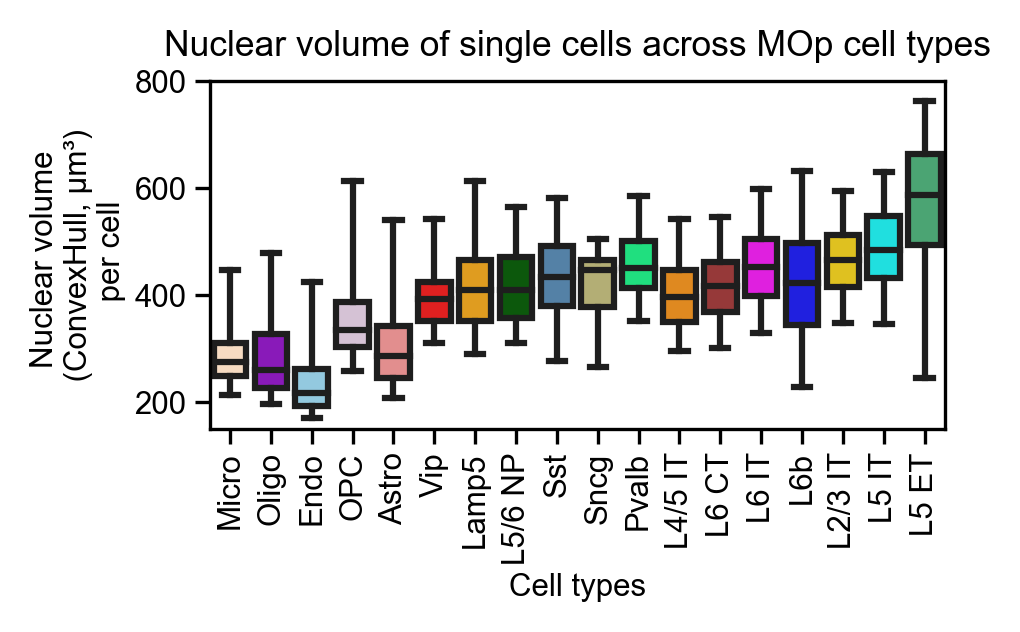

In [27]:
%matplotlib inline

import seaborn as sns
import scanpy as sc
min_pts_th = 1250

# sort plotting order by meadian of groups
df_plot = sel_merged_cell_volume_df[sel_merged_cell_volume_df['total_spots']>=min_pts_th]

# plot
#fig, ax = plt.subplots(figsize=(_page_width/3*5/2.5,_page_width/3),dpi=150)
fig, ax = plt.subplots(figsize=(_page_width/3.5*5/2.5,_page_width/3.6),dpi=150)

sns.boxplot(data=df_plot, x='subclass', y='nucleus_volume', 
            order = sorted_cellplot_order, 
            ax=ax, 
            fliersize=0,
            whis=[5, 95],
            #boxprops={'linewidth': 0.5}
            palette=celltype_palette)

#ax.set_xticklabels(sorted_types, rotation=70, fontsize=12)
plt.tick_params(axis='y', labelsize=_font_size, pad=2) 
plt.tick_params(axis='x', rotation=90, labelsize=_font_size, pad=2) 

ax.set_xlabel("Cell types", fontsize=_font_size, labelpad=2)
ax.set_ylabel("Nuclear volume \n (ConvexHull, \u03bcm\u00b3) \n per cell", fontsize=_font_size, labelpad=2)
ax.set_title(f"Nuclear volume of single cells across MOp cell types", fontsize=_font_size+1, y=1)

#ax.set_xticklabels(sorted_types, rotation=70, fontsize=12)
plt.tick_params(axis='y', labelsize=_font_size) 
plt.tick_params(axis='x', rotation=90, labelsize=_font_size) 


#ax.set_xlim([0,3050])
ax.set_ylim([150,800])
ax.grid(False)

plt.savefig(os.path.join(output_figure_folder, f'Nucleus_size_ConvexHull.pdf'), 
            transparent=True, dpi=300, bbox_inches='tight')

plt.show()

### Correlate 10x snRNA and nucleus size

In [28]:
df_plot_median = pd.DataFrame(df_plot.groupby(by='subclass')['nucleus_volume'].median())
df_plot_median['total_counts'] = sel_measure_df.groupby(by='subclass_label_new')['total_counts'].median()
df_plot_median['n_genes_by_counts'] = sel_measure_df.groupby(by='subclass_label_new')['n_genes_by_counts'].median()
df_plot_median['celltype'] = df_plot_median.index
df_plot_median

,nucleus_volume,total_counts,n_genes_by_counts,celltype
subclass,,,,
Astro,285.322546,6120.0,1885.0,Astro
Endo,216.955357,4115.0,1625.0,Endo
L2/3 IT,465.983908,18831.0,3755.0,L2/3 IT
L4/5 IT,397.059153,14654.0,3256.0,L4/5 IT
L5 ET,585.822123,27830.5,4710.5,L5 ET
L5 IT,484.328127,21118.0,3954.0,L5 IT
L5/6 NP,409.126734,10853.0,2807.0,L5/6 NP
L6 CT,416.027680,14703.0,3269.0,L6 CT
L6 IT,452.559266,17063.0,3530.0,L6 IT


meta NOT subset; don't know how to subset; dropped


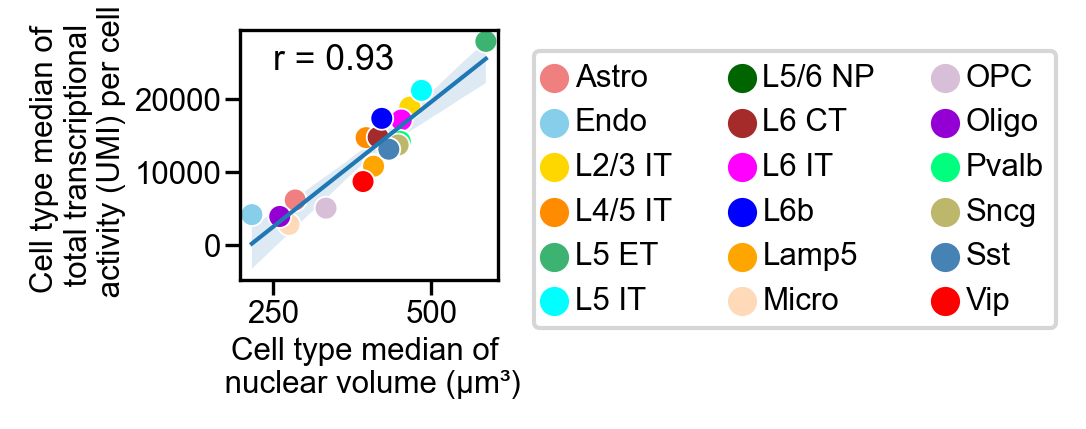

In [31]:
# plot
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=(_page_width/5,_page_width/5),dpi=150)

x_col = 'nucleus_volume'
y_col = 'total_counts'


# correlation
X=df_plot_median[x_col].values.reshape(-1, 1)
y=df_plot_median[y_col].values.reshape(-1, 1)
reg = LinearRegression(fit_intercept=True).fit(X, y)
y_pred = reg.predict(X)
#ax.plot(X,y_pred,'r--',alpha=0.6)


gfg = sns.regplot(data=df_plot_median, x= x_col, y = y_col, ax=ax,
                  ci=95,scatter=False,
                  line_kws={'linewidth':1}
                 )
gfg = sns.scatterplot(data=df_plot_median, 
                      x= x_col, y = y_col, ax=ax,
                        #legend='full',
                        hue ='celltype',
                      #linewidth = 0,
                        palette=celltype_palette,
                        s=30,
                   )
plt.legend(bbox_to_anchor=(1.02, 1.04), loc='upper left', ncols=3, borderaxespad=1,fontsize=_font_size)
#ax.text(250,24000,f'r\u00b2 = {round(reg.score(X, y),2)}',fontsize=_font_size+1)

from scipy.stats import pearsonr
r_val = pearsonr(df_plot_median[x_col].values, df_plot_median[y_col].values)[0]
ax.text(250,24000,f'r = {round(r_val,2)}',fontsize=_font_size+1)


ax.tick_params('x', labelsize=_font_size, 
                    #width=_ticklabel_width, length=_ticklabel_size,
                    pad=1, labelbottom=True) # remove bottom ticklabels for _ax
ax.tick_params('y', labelsize=_font_size, 
                #width=_ticklabel_width, #length=0,
                pad=1, labelleft=True)


ax.set_xlabel('Cell type median of \n nuclear volume (\u03bcm\u00b3)',fontsize=_font_size,labelpad=2)

ax.set_ylabel(f'Cell type median of \n total transcriptional \n activity (UMI) per cell', fontsize=_font_size, labelpad=2)


ax.grid(False)

plt.savefig(os.path.join(output_figure_folder, f'Corr_Nucleus_ConvexHull_and_10x_snUMI.pdf'), 
            transparent=True, dpi=300, bbox_inches='tight')

plt.show()
    

## Total chromatin accessibility and nucleus size

### 10x snATACseq data

Data below can be generated using the notebook as:

[external/scripts/sn_atac/3_label_atac_anndata_mop_episcanpy](../../external/scripts/sn_atac/3_label_atac_anndata_mop_episcanpy.ipynb)

In [32]:
import scanpy as sc
#import os

data_path = r'L:\Shiwei\DNA_MERFISH_analysis\Analysis_MOp_methylation_ATAC\data\EckerRen_Mouse_MOp_methylation_ATAC'

atac_adata_ori  = sc.read(os.path.join(data_path,r'MOp_ATAC_combined_labeled.h5ad'))

In [33]:
measure_df4 = atac_adata_ori.obs[['UM','nb_features','subclass_label_new','class_label_new','neuron_identity']]
sel_measure_df4 = measure_df4[measure_df4['subclass_label_new'].isin(sorted_cellplot_order)]
sel_measure_df4

,UM,nb_features,subclass_label_new,class_label_new,neuron_identity
4,17586.0,4047,L5 IT,Gluta,Neuronal
5,13837.0,3585,L6 CT,Gluta,Neuronal
6,26303.0,8088,L6 IT,Gluta,Neuronal
8,42880.0,11948,L5 IT,Gluta,Neuronal
9,2655.0,729,L2/3 IT,Gluta,Neuronal
...,...,...,...,...,...
135661,10475.0,4441,L2/3 IT,Gluta,Neuronal
135662,1854.0,893,OPC,Oligo,Non-Neuronal
135663,8636.0,3705,L6 CT,Gluta,Neuronal
135664,1591.0,583,Oligo,Oligo,Non-Neuronal


In [34]:
sub_sorted_cellplot_order =['Micro', 'Oligo', 'Endo', 'OPC', 'Astro', 
                  'L5/6 NP', 'Sst',  'Pvalb', 'L4/5 IT', 'L6 CT',
                  'L6 IT', 'L2/3 IT', 'L5 IT', 'L5 ET']

### Re-define selected nucleus size dataframe

In [35]:
selected_cell_labels = ['L2/3 IT','L4/5 IT','L5 IT','L6 IT','L5 ET','L5/6 NP','L6 CT','L6b',
                           'Sst','Pvalb','Lamp5',
                           'Astro','Oligo','OPC','Micro','Endo','Peri', 
                           
                          ]

celltype_palette = {'Astro':'lightcoral', 
                    'Endo':'skyblue', 
                    'L2/3 IT':'gold', 
                    'L4/5 IT':'darkorange', 
                    'L5 ET':'mediumseagreen', 
                    'L5 IT':'aqua',
                    'L5/6 NP':'darkgreen',
                    'L6 CT':'brown',
                    'L6 IT':'magenta',
                    'L6b':'blue', 
                    'Lamp5':'orange', 
                    'Micro':'peachpuff',
                    'OPC':'thistle', 
                    'Oligo':'darkviolet',
                    'Peri':'sandybrown',
                    'Pvalb':'springgreen',
                    'SMC':'rosybrown',
                    'Sncg':'darkkhaki',
                    'Sst':'steelblue', 
                    'VLMC':'saddlebrown', 
                    'Vip':'red',
                    'other':'slategray'}


sel_merged_cell_volume_df = merged_cell_volume_df[merged_cell_volume_df['subclass'].isin(sorted_cellplot_order)]
# sort plotting order by meadian of groups
df_plot = sel_merged_cell_volume_df[sel_merged_cell_volume_df['total_spots']>=min_pts_th]
print(min_pts_th)

1250


### Correlate 10x snATAC and nucleus size

In [36]:
df_plot_median = pd.DataFrame(df_plot.groupby(by='subclass')['nucleus_volume'].median())
df_plot_median['total_counts'] = sel_measure_df4.groupby(by='subclass_label_new')['UM'].median()
df_plot_median['n_genes_by_counts'] = sel_measure_df4.groupby(by='subclass_label_new')['nb_features'].median()
df_plot_median['celltype'] = df_plot_median.index
df_plot_median = df_plot_median.dropna()
df_plot_median

,nucleus_volume,total_counts,n_genes_by_counts,celltype
subclass,,,,
Astro,285.322546,3708.5,1358.0,Astro
Endo,216.955357,3214.0,1246.5,Endo
L2/3 IT,465.983908,6993.0,2841.0,L2/3 IT
L4/5 IT,397.059153,6227.5,2348.5,L4/5 IT
L5 ET,585.822123,8542.0,3863.0,L5 ET
L5 IT,484.328127,7838.5,3224.0,L5 IT
L5/6 NP,409.126734,5120.5,1990.5,L5/6 NP
L6 CT,416.027680,6381.0,2493.0,L6 CT
L6 IT,452.559266,7009.0,2793.0,L6 IT


meta NOT subset; don't know how to subset; dropped


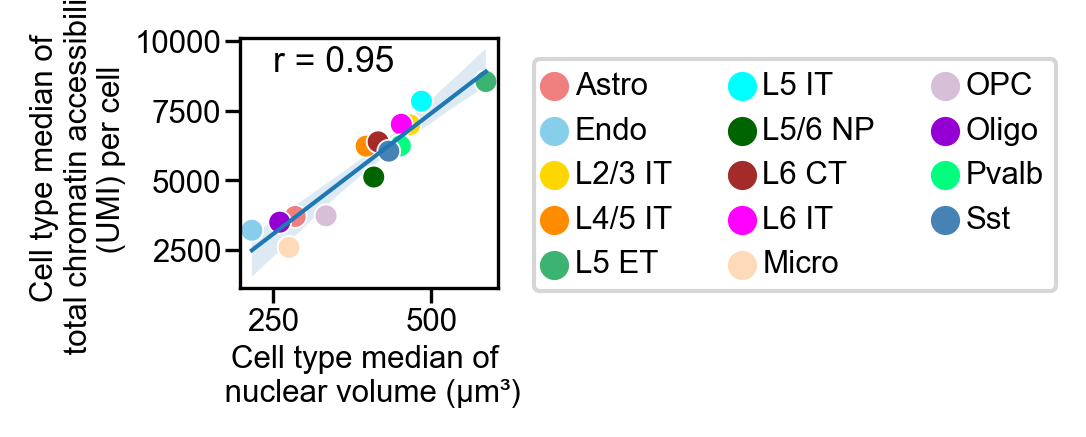

In [37]:
# plot
from sklearn.linear_model import LinearRegression
fig, ax = plt.subplots(figsize=(_page_width/5,_page_width/5),dpi=150)

x_col = 'nucleus_volume'
y_col = 'total_counts'


# correlation
X=df_plot_median[x_col].values.reshape(-1, 1)
y=df_plot_median[y_col].values.reshape(-1, 1)
reg = LinearRegression(fit_intercept=True).fit(X, y)
y_pred = reg.predict(X)


gfg = sns.regplot(data=df_plot_median, x= x_col, y = y_col, ax=ax,
                  ci=95,scatter=False,
                  line_kws={'linewidth':1}
                 )
gfg = sns.scatterplot(data=df_plot_median, 
                      x= x_col, y = y_col, ax=ax,
                        #legend='full',
                        hue ='celltype',
                      #linewidth = 0,
                        palette=celltype_palette,
                        s=30,
                   )
plt.legend(bbox_to_anchor=(1.02, 1.04), loc='upper left', ncols=3, borderaxespad=1,fontsize=_font_size)
#ax.text(250,8900,f'r\u00b2 = {round(reg.score(X, y),2)}',fontsize=_font_size+1)

from scipy.stats import pearsonr
r_val = pearsonr(df_plot_median[x_col].values, df_plot_median[y_col].values)[0]
ax.text(250,8900,f'r = {round(r_val,2)}',fontsize=_font_size+1)

# axes options
#ax.set_ylim([200,700])
ax.tick_params('x', labelsize=_font_size, 
                    #width=_ticklabel_width, length=_ticklabel_size,
                    pad=1, labelbottom=True) # remove bottom ticklabels for _ax
ax.tick_params('y', labelsize=_font_size, 
                #width=_ticklabel_width, #length=0,
                pad=1, labelleft=True)

#ax.set_xlabel(f'nucleus size -median', fontsize=_font_size, labelpad=5)
ax.set_xlabel('Cell type median of \n nuclear volume (\u03bcm\u00b3)',fontsize=_font_size,labelpad=2)

ax.set_ylabel(f'Cell type median of \n total chromatin accessibility \n (UMI) per cell', fontsize=_font_size, labelpad=2)


ax.grid(False)

plt.savefig(os.path.join(output_figure_folder, f'Corr_Nucleus_ConvexHull_and_10x_snATAC_UM.pdf'), 
            transparent=True, dpi=300, bbox_inches='tight')

plt.show()
    

meta NOT subset; don't know how to subset; dropped


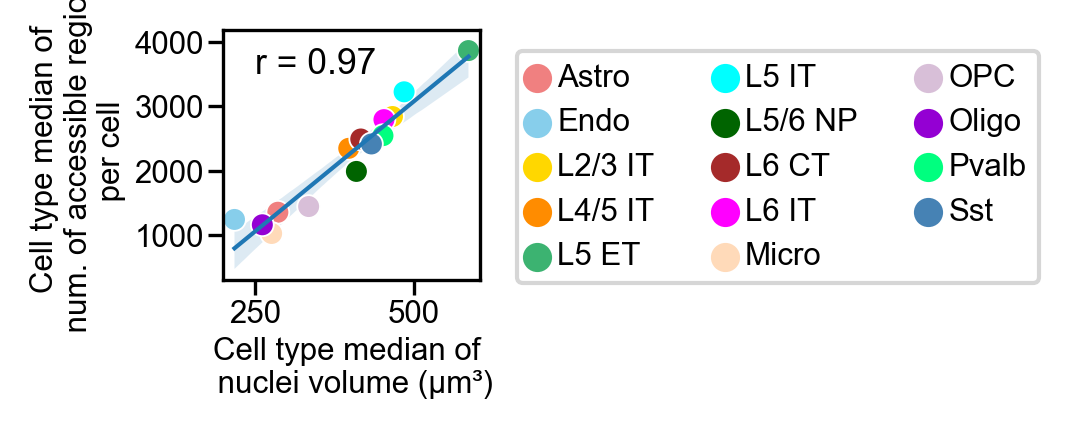

In [38]:
# plot
from sklearn.linear_model import LinearRegression
fig, ax = plt.subplots(figsize=(_page_width/5,_page_width/5),dpi=150)

x_col = 'nucleus_volume'
y_col = 'n_genes_by_counts'


# correlation
X=df_plot_median[x_col].values.reshape(-1, 1)
y=df_plot_median[y_col].values.reshape(-1, 1)
reg = LinearRegression(fit_intercept=True).fit(X, y)
y_pred = reg.predict(X)


gfg = sns.regplot(data=df_plot_median, x= x_col, y = y_col, ax=ax,
                  ci=95,scatter=False,
                  line_kws={'linewidth':1}
                 )
gfg = sns.scatterplot(data=df_plot_median, 
                      x= x_col, y = y_col, ax=ax,
                        #legend='full',
                        hue ='celltype',
                      #linewidth = 0,
                        palette=celltype_palette,
                        s=30,
                   )
plt.legend(bbox_to_anchor=(1.02, 1.04), loc='upper left', ncols=3, borderaxespad=1,fontsize=_font_size)
#ax.text(250,3500,f'r\u00b2 = {round(reg.score(X, y),2)}',fontsize=_font_size+1)

from scipy.stats import pearsonr
r_val = pearsonr(df_plot_median[x_col].values, df_plot_median[y_col].values)[0]
ax.text(250,3500,f'r = {round(r_val,2)}',fontsize=_font_size+1)

# axes options
#ax.set_ylim([200,700])
ax.tick_params('x', labelsize=_font_size, 
                    #width=_ticklabel_width, length=_ticklabel_size,
                    pad=1, labelbottom=True) # remove bottom ticklabels for _ax
ax.tick_params('y', labelsize=_font_size, 
                #width=_ticklabel_width, #length=0,
                pad=1, labelleft=True)


#ax.set_xlabel(f'nucleus size -median', fontsize=_font_size, labelpad=5)
ax.set_xlabel('Cell type median of \n nuclei volume (\u03bcm\u00b3)',fontsize=_font_size,labelpad=2)

ax.set_ylabel(f'Cell type median of \n num. of accessible region \n per cell', fontsize=_font_size, labelpad=2)

ax.grid(False)

plt.savefig(os.path.join(output_figure_folder, f'Corr_Nucleus_ConvexHull_and_10x_snATAC_NGbyC.pdf'), 
            transparent=True, dpi=300, bbox_inches='tight')

plt.show()
    